Lambda School Data Science

*Unit 2, Sprint 2, Module 3*

---

# Cross-Validation


## Assignment
- [ ] [Review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Continue to participate in our Kaggle challenge. 
- [ ] Use scikit-learn for hyperparameter optimization with RandomizedSearchCV.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


You won't be able to just copy from the lesson notebook to this assignment.

- Because the lesson was ***regression***, but the assignment is ***classification.***
- Because the lesson used [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html), which doesn't work as-is for _multi-class_ classification.

So you will have to adapt the example, which is good real-world practice.

1. Use a model for classification, such as [RandomForestClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
2. Use hyperparameters that match the classifier, such as `randomforestclassifier__ ...`
3. Use a metric for classification, such as [`scoring='accuracy'`](https://scikit-learn.org/stable/modules/model_evaluation.html#common-cases-predefined-values)
4. If you’re doing a multi-class classification problem — such as whether a waterpump is functional, functional needs repair, or nonfunctional — then use a categorical encoding that works for multi-class classification, such as [OrdinalEncoder](https://contrib.scikit-learn.org/categorical-encoding/ordinal.html) (not [TargetEncoder](https://contrib.scikit-learn.org/categorical-encoding/targetencoder.html))



## Stretch Goals

### Reading
- Jake VanderPlas, [Python Data Science Handbook, Chapter 5.3](https://jakevdp.github.io/PythonDataScienceHandbook/05.03-hyperparameters-and-model-validation.html), Hyperparameters and Model Validation
- Jake VanderPlas, [Statistics for Hackers](https://speakerdeck.com/jakevdp/statistics-for-hackers?slide=107)
- Ron Zacharski, [A Programmer's Guide to Data Mining, Chapter 5](http://guidetodatamining.com/chapter5/), 10-fold cross validation
- Sebastian Raschka, [A Basic Pipeline and Grid Search Setup](https://github.com/rasbt/python-machine-learning-book/blob/master/code/bonus/svm_iris_pipeline_and_gridsearch.ipynb)
- Peter Worcester, [A Comparison of Grid Search and Randomized Search Using Scikit Learn](https://blog.usejournal.com/a-comparison-of-grid-search-and-randomized-search-using-scikit-learn-29823179bc85)

### Doing
- Add your own stretch goals!
- Try other [categorical encodings](https://contrib.scikit-learn.org/categorical-encoding/). See the previous assignment notebook for details.
- In additon to `RandomizedSearchCV`, scikit-learn has [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). Another library called scikit-optimize has [`BayesSearchCV`](https://scikit-optimize.github.io/notebooks/sklearn-gridsearchcv-replacement.html). Experiment with these alternatives.
- _[Introduction to Machine Learning with Python](http://shop.oreilly.com/product/0636920030515.do)_ discusses options for "Grid-Searching Which Model To Use" in Chapter 6:

> You can even go further in combining GridSearchCV and Pipeline: it is also possible to search over the actual steps being performed in the pipeline (say whether to use StandardScaler or MinMaxScaler). This leads to an even bigger search space and should be considered carefully. Trying all possible solutions is usually not a viable machine learning strategy. However, here is an example comparing a RandomForestClassifier and an SVC ...

The example is shown in [the accompanying notebook](https://github.com/amueller/introduction_to_ml_with_python/blob/master/06-algorithm-chains-and-pipelines.ipynb), code cells 35-37. Could you apply this concept to your own pipelines?


### BONUS: Stacking!

Here's some code you can use to "stack" multiple submissions, which is another form of ensembling:

```python
import pandas as pd

# Filenames of your submissions you want to ensemble
files = ['submission-01.csv', 'submission-02.csv', 'submission-03.csv']

target = 'status_group'
submissions = (pd.read_csv(file)[[target]] for file in files)
ensemble = pd.concat(submissions, axis='columns')
majority_vote = ensemble.mode(axis='columns')[0]

sample_submission = pd.read_csv('sample_submission.csv')
submission = sample_submission.copy()
submission[target] = majority_vote
submission.to_csv('my-ultimate-ensemble-submission.csv', index=False)
```

## Data Ingestion

In [32]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [65]:
import pandas as pd

# Merge train_features.csv & train_labels.csv
train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))

sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

In [66]:
# These are baseline percentages.
status_percentages = train['status_group'].value_counts(normalize=True)
functional_percentage, non_functional_percentage, functional_needs_repair_percentage  = status_percentages

print(f'{functional_percentage, non_functional_percentage, functional_needs_repair_percentage}')
print(f'Baseline percentage of pumps that are functional:{round(100*functional_percentage,2)}%')

(0.543080808080808, 0.3842424242424242, 0.07267676767676767)
Baseline percentage of pumps that are functional:54.31%


## Wrangle data.

In [67]:
import numpy as np

def wrangle(X):
    """A standard set of steps to wrangle data in sets."""
    
    # Make a copy to prevent damaging provided df in case of error.
    X = X.copy()
    
    # Replace weird lats and longs with nan, to be cleaned in pipeline.
    X['latitude'] = X['latitude'].replace(-2e-08, 0)
    
    # Replace zeroes in some columns with nan, to be cleaned.
    cols_with_zeros = ['longitude', 'latitude'
                       ,'gps_height'
                       ,'construction_year'
                      ]
    for col in cols_with_zeros:
        X[col] = X[col].replace(0, np.nan)

    # The columns 'quantity' & 'quantity_group' are duplicates, so we drop one.
    X = X.drop(columns='quantity_group')
    
    dict_status_group_to_int = {'non functional' : 0, 'functional needs repair' : 1, 'functional' : 2}
    
    X['status_group'] =  X['status_group'].map(dict_status_group_to_int) 
    
    # return the wrangled dataframe.
    return X

In [68]:
train = wrangle(train)
train.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,...,payment_type,water_quality,quality_group,quantity,source,source_type,source_class,waterpoint_type,waterpoint_type_group,status_group
0,69572,6000.0,2011-03-14,Roman,1390.0,Roman,34.938093,-9.856322,none,0,...,annually,soft,good,enough,spring,spring,groundwater,communal standpipe,communal standpipe,2
1,8776,0.0,2013-03-06,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,0,...,never pay,soft,good,insufficient,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2
2,34310,25.0,2013-02-25,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,0,...,per bucket,soft,good,enough,dam,dam,surface,communal standpipe multiple,communal standpipe,2
3,67743,0.0,2013-01-28,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,0,...,never pay,soft,good,dry,machine dbh,borehole,groundwater,communal standpipe multiple,communal standpipe,0
4,19728,0.0,2011-07-13,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,0,...,never pay,soft,good,seasonal,rainwater harvesting,rainwater harvesting,surface,communal standpipe,communal standpipe,2


In [37]:
# # Pandas Profiling can be very slow with medium & large datasets.
# # These parameters will make it faster.
# # https://github.com/pandas-profiling/pandas-profiling/issues/222

# import pandas_profiling

# profile_report = train.profile_report(
#     check_correlation_pearson=False,
#     correlations={
#         'pearson': False,
#         'spearman': False,
#         'kendall': False,
#         'phi_k': False,
#         'cramers': False,
#         'recoded': False,
#     },
#     plot={'histogram': {'bayesian_blocks_bins': False}},
# )

# TODO 
# # convert date_recoreded to datetime with pd.to_datetime()
# print("Boo")
# profile_report

## Select Features

In [69]:
# The value to be predicted is 'status_group'.
target = 'status_group'

# Define initial features. Drop spurious 'id', and the target feature.
train_features = train.drop(columns=['id', target])

# Get numeric features (as a Pandas series).
numeric_features = train_features.select_dtypes(include='number').columns.tolist()

# Get non-numeric features with relatively low cardinality.
## Get the cardinality of the NON-numeric features (as a Pandas series).
cardinality = train_features.select_dtypes(exclude='number').nunique()

## Get a list of all categorical features with cardinality below (or) 50.
categorical_features = cardinality[cardinality <= 50].index.tolist()

# Concatenate the two series to list all features.
features = numeric_features + categorical_features
# print(features)

In [70]:
## Define X matrix and y vector

In [71]:
y_train = train[target]
X_train = train[features]
X_train.shape

(59400, 30)

In [72]:
from sklearn.pipeline import make_pipeline
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from sklearn.feature_selection import f_regression, SelectKBest
from sklearn.ensemble import RandomForestRegressor

from sklearn.model_selection import cross_val_score

In [74]:
features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

RFR_pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1),
    SimpleImputer(strategy='median'),
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=1984)
)

k=3
scores = cross_val_score(RFR_pipeline, X_train, y_train, cv=k,
                        scoring='neg_mean_absolute_error')

print(f'MAE for {k} folds: ', -scores)


MAE for 3 folds:  [0.47509495 0.4782596  0.47238687]


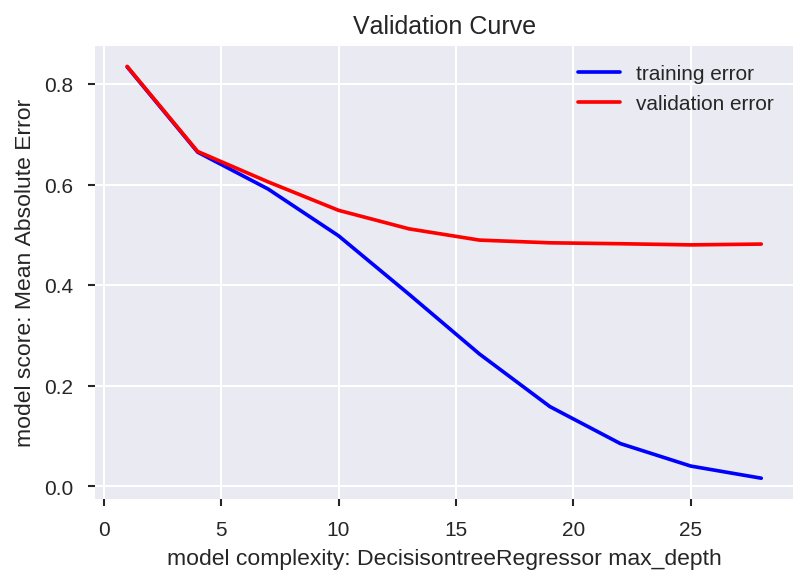

In [93]:
import matplotlib.pyplot as plt
from sklearn.model_selection import validation_curve
from sklearn.tree import DecisionTreeRegressor

decision_tree_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeRegressor(random_state=1984)
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    decision_tree_pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth',
    param_range=depth, scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label = 'training error',)
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: DecisisontreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
# plt.ylim((500,700)) # Zoom
plt.legend();

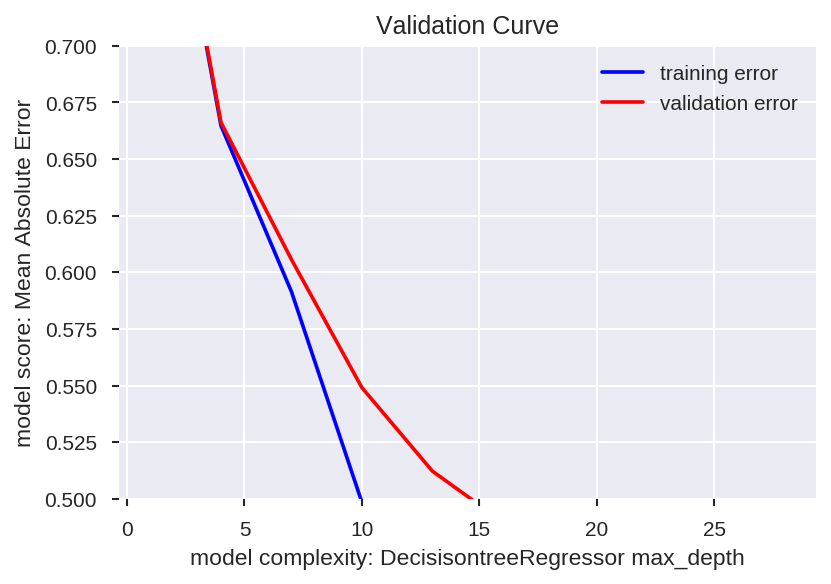

In [95]:
decision_tree_pipeline = make_pipeline(
    ce.OrdinalEncoder(),
    SimpleImputer(),
    StandardScaler(),
    DecisionTreeRegressor(random_state=1984)
)

depth = range(1, 30, 3)
train_scores, val_scores = validation_curve(
    decision_tree_pipeline, X_train, y_train,
    param_name='decisiontreeregressor__max_depth',
    param_range=depth, scoring='neg_mean_absolute_error',
    cv=3,
    n_jobs=-1
)

plt.figure(dpi=150)
plt.plot(depth, np.mean(-train_scores, axis=1), color='blue', label = 'training error',)
plt.plot(depth, np.mean(-val_scores, axis=1), color='red', label='validation error')
plt.title('Validation Curve')
plt.xlabel('model complexity: DecisisontreeRegressor max_depth')
plt.ylabel('model score: Mean Absolute Error')
plt.ylim((0.500,0.700)) # Zoom
plt.legend();

## Cross Validation

In [97]:
from sklearn.ensemble import RandomForestRegressor

features = train.columns.drop(target)
X_train = train[features]
y_train = train[target]

pipeline = make_pipeline(
    ce.TargetEncoder(min_samples_leaf=1, smoothing=1), 
    SimpleImputer(strategy='median'), 
    RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42)
)

k = 3
scores = cross_val_score(pipeline, X_train, y_train, cv=k, 
                         scoring='neg_mean_absolute_error')
print(f'MAE for {k} folds:', -scores)

MAE for 3 folds: [0.47425202 0.47905455 0.47361616]


In [117]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score

rand_search_pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True),
    SimpleImputer(),
    StandardScaler(),
    RandomForestClassifier(n_estimators=20, criterion='gini', 
                          n_jobs=-1, random_state=1984)
)

param_distributions = {
    'simpleimputer__strategy' : ['mean', 'median'],
    'randomforestclassifier__min_samples_split':  [2,3,4],
    'randomforestclassifier__min_samples_split':  [20,30,40],
    'randomforestclassifier__max_features': uniform(0,1)
}

search = RandomizedSearchCV(
    rand_search_pipeline,
    param_distributions=param_distributions,
    n_iter = 10,
    cv=5,
    scoring='accuracy',
    verbose=10,
    return_train_score=True,
    n_jobs=-1
)

search.fit(X_train, y_train);

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:    6.1s


MemoryError: Unable to allocate array with shape (30628, 30628) and data type int64